<a href="https://colab.research.google.com/github/AeneasWeiChiHsu/AeneasWeiChiHsu/blob/main/DQN_CarRacing_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> 因為我不會開車，所以我決定訓練一個Agent來開車。

本集特別感謝：IBM 在 Coursera 上的線上課程 [Deep Learning with Keras and TensorFlow](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/home)

詳細內容請參考：[Building a Deep Q-Network with Keras](https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/ungradedLti/AlszB/lab-building-a-deep-q-network-with-keras)

本集特別感謝：University of Alberta 在 Coursera 上的線上課程 [Fundamentals of Reinforcement Learning](https://www.coursera.org/learn/fundamentals-of-reinforcement-learning/home)


# Goal: Deep Q-Network with Keras

故事是這樣的，我之前上過一門課，叫做《控制理論》，但是內容都是在講 Reinforcement Learning。
不過那個時候我什麼都不懂，只是想要做完期末專題：CarRacing。
所以我在Github上面看到有人 share 了一段 DualDQN 的code，我覺得很棒，我就拿來改。
最後那個不是我的 Agent 幫我完成了我的 Final Project。
不過那段 Code 是用 pytorch 寫的。但是基於某些理由我不喜歡 pytorch。
現在我要做這個 Project。

## Box2D

請參考 OpenAI gymnasium 的說明來安裝相對應的東西
https://gymnasium.farama.org/environments/box2d/

In [1]:
# Instal Gym
!pip install gymnasium
! pip install swig
! pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379372 sha256=9ad3a0b675d321f4c9ee6729c0a7c5a3afe8b26da17191e5e7e148cdbaecb5e2
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from collections import deque
from tensorflow.keras.models import Model

# ==== Layers ====
from tensorflow.keras.layers import Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Activation, Lambda, Add, LayerNormalization, LeakyReLU, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, ZeroPadding2D, Cropping2D, ZeroPadding1D, Cropping1D, Layer

# ==== Optimizer ====
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

# ==== Callbacks ====
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
from tqdm import tqdm
from tqdm import trange
from collections import Counter
# ==== Video ====
import imageio
import os

# Environment

https://gymnasium.farama.org/environments/box2d/car_racing/

Actions = [do nothing, left, right, gas, brake]

Observation = **A top-down 96x96 RGB image of the car and race track.**


In [29]:
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

env.close()

In [20]:
# ==== Reproducibility ====
np.random.seed(1984)
tf.random.set_seed(1984)
env.reset(seed = 1984)

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {})

# Model

In [57]:
# ==== Build Model ====
def build_model (input_shape = (96, 96, 3), action_size = 5):
  inputs = Input(shape = input_shape)

  # Normalize pixel [0,255] → [0,1]
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  # ==== Convolution Layers ====
  # Don't use BatchNormalization()
  x = Conv2D(32, (8, 8), strides=4, activation = None)(x)
  x = LeakyReLU()(x)

  x = Conv2D(64, (4, 4), strides=2, activation = None)(x)
  x = LeakyReLU()(x)

  x = Conv2D(64, (3, 3), strides=1, activation = None)(x)
  x = LeakyReLU()(x)


  # ==== Flaten ====
  x = Flatten()(x)

  # ==== Deep Layers ====
  #x = Dense(512, activation='relu')(x)
  #x = Dropout(0.2)(x)

  #x = Dense(256, activation='relu')(x)
  #x = Dropout(0.2)(x)

  #x = Dense(128, activation='relu')(x)

  #x = Dense(64, activation='relu')(x)

  # ==== Dueling DQN =====
  # Two head mechanism
  # Advantage Stream
  a = Dense(256, activation='relu', name = 'Advantage_Stream_1')(x)
  a = Dense(256, activation='relu', name = 'Advantage_Stream_2')(x)
  a = Dense(action_size)(a)


  # Value Stream
  v = Dense(256, activation='relu', name = 'Value_Stream_1')(x)
  v = Dense(256, activation='relu', name = 'Value_Stream_2')(x)
  v = Dense(1)(v)

  # ==== Output ====
  # Q-values for each discrete action
  # Output: q_values = [[12.3, 11.8, 9.5, 14.2, 13.0]]
  # The q_values of each action
  # i.e., Q(s, a = 0) = 12.3
  # i.e., Q(s, a =1) = 11.8
  # outputs = Dense(action_size, activation='linear', name = 'Q-values')(x)

  # ==== Dueling DQN Output ====
  # Q(s, a) = V(s) + (A(s, a) - mean(A(s, a')))
  # V(s) -> (batch_size, 1)
  # A(s, a) -> (batch_size, action_size)
  outputs = Lambda(lambda x: x[0] + (x[1] - tf.reduce_mean(x[1], axis=1, keepdims=True)))([v, a])

  # ==== Model Build ====
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=Adam(learning_rate=0.00025), loss='mse')

  return model

# ==== Car Racing parameters ====
state_size = 96*96*3
action_size = 5

# ====
model = build_model(input_shape = (96, 96, 3), action_size = 5)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 96, 96, 3) │          0 │ input_layer_7[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 23, 23,    │      6,176 │ rescaling_7[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 23, 23,    │          0 │ conv2d_21[0][0]   │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 10, 10,    │     32,832 │ leaky_re_lu_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 10, 10,    │          0 │ conv2d_22[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 8, 8, 64)  │          0 │ conv2d_23[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 4096)      │          0 │ leaky_re_lu_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Value_Stream_2      │ (None, 256)       │  1,048,832 │ flatten_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Advantage_Stream_2  │ (None, 256)       │  1,048,832 │ flatten_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1)         │        257 │ Value_Stream_2[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 5)         │      1,285 │ Advantage_Stream… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 5)         │          0 │ dense_44[0][0],   │
│                     │                   │            │ dense_43[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,175,142 (8.30 MB)

 Trainable params: 2,175,142 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

# Implement the replay buffer

In [62]:
memory = deque(maxlen=10000)
def remember(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# Epsilon Greedy Policy (Act)

In [63]:
# ==== Epsilon Greedy Policy ====

# exploration rate
epsilon = 1.0
# minimum exploration rate
epsilon_min = 0.01
# dacay rate for epsilon after each episode
epsilon_decay = 0.995

# ==== Action ====
# act(): chooses an action based on the epsilon-greedy policy.
def act(state):
    global epsilon
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)
    # Add batch dimension
    # state: (96, 96, 3)
    # state[np.newaxis, ...]: (1, 96, 96, 3)
    # CNN model input: (batch_size, 96, 96, 3)
    q_values = model.predict(state[np.newaxis, ...], verbose=0)
    return np.argmax(q_values[0])

# Q-learning Update (Replay)

我們用之前的經驗來訓練DQN。
基本上經驗會放在一個baffur裡面。我們叫他 replay buffer。

In [64]:
# ==== Replay ====
def replay(batch_size):
  global epsilon

  # From memory, we extract experience to train
  minibatch = random.sample(memory, batch_size)

  for state, action, reward, next_state, done in minibatch:

    # Q-value
    # Default: Q-value = Reward
    # If done = terminated (no future)
    target = reward

    # Update Rule
    # If the game keeps running, update it
    if not done:
      # Update Q-value based on Bellman's equation
      # CNN Input: (1, 96, 96, 3)
      # Predict next step's Q-value: argmax Q(s', a')
      target = reward + gamma * np.amax(model.predict(next_state[np.newaxis, ...], verbose=0)[0])

    # Update Q-value
    # CNN Input: (1, 96, 96, 3)
    # Note the argument in "model.predict(state)" is wrong.
    # Take the prediction value of current Q(s, a)
    target_f = model.predict(state[np.newaxis, ...], verbose=0)

    # Choose an action
    # Q(s, a) = target
    # Update Q(s, a): Only based on the selected action
    target_f[0][action] = target

    # Train the model on the update Q-value
    # Use target_f as label to train the model
    # Goal: make the model predict the Q(s, a) approximates target
    model.fit(state[np.newaxis, ...], target_f, epochs=1, verbose=0)

  # Decay: epsilon decay
  if epsilon > epsilon_min:
    epsilon *= epsilon_decay

# Training Loop

In [65]:
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)


# ==== Training Parameters ====
episodes = 1000 # More is good
batch_size = 128 # Minibatch size
gamma = 0.95 # Discount rate (~1 future is import)
max_step = 1000 # Max step per eposide
best_score = -np.inf


# ==== Training Loop ====
for episode in range(episodes):
  action_history = []
  state = env.reset()
  episode_reward =0.0

  if isinstance(state, tuple):
    state = state[0]

  for time in range(max_step):
    # Choose action using epsilon-greedy policy
    # act() → strategy
    action = act(state)
    action_history.append(action)

    # Take action
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    # Punish the stay
    if action == 0:
      reward = float(reward) - 0.1

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    # Remember
    # Store experience in memory
    # remember → memorize (replay buffer)
    remember(state, action, reward, next_state, done)

    # Update state
    state = next_state

    # Record reward
    episode_reward = episode_reward + float(reward)

    # If episode ends
    if done:
      print(f"Episode: {episode+1}/{episodes}, Score: {episode_reward:.2f}, Epsilon: {epsilon:.2f}")
      break

  #Train the model using replay memory
  replay_start = 5000  # 可調
  if len(memory) > replay_start and len(memory) > batch_size:
    replay(batch_size)

  # Test
  if episode % 10 == 0:
      test_env = gym.make("CarRacing-v3", render_mode="rgb_array", continuous=False)
      obs, _ = test_env.reset()
      for _ in range(200):
          action = np.argmax(model.predict(obs[np.newaxis, ...], verbose=0)[0])
          obs, _, terminated, truncated, _ = test_env.step(action)
          if terminated or truncated:
              break
      test_env.close()

  # Update Best Score
  if episode_reward > best_score:
    best_score = episode_reward
    model.save('best_model.keras')
    print(f"✅New Best Score {best_score}")

  print("Top actions in this episode:", Counter(action_history).most_common())
  print("======================================")

print(f"Training complete after {episodes} episodes.")
print(f"Best model score: {best_score:.2f}")
env.close()


Episode: 1/1000, Score: -80.02, Epsilon: 1.00
✅New Best Score -80.01526717557283
Top actions in this episode: [(0, 220), (1, 208), (2, 204), (4, 202), (3, 166)]
Episode: 2/1000, Score: -66.56, Epsilon: 1.00
✅New Best Score -66.55539033457325
Top actions in this episode: [(4, 208), (3, 204), (1, 201), (2, 201), (0, 186)]
Episode: 3/1000, Score: -79.57, Epsilon: 1.00
Top actions in this episode: [(4, 214), (1, 203), (3, 199), (0, 197), (2, 187)]
Episode: 4/1000, Score: -71.46, Epsilon: 1.00
Top actions in this episode: [(2, 225), (1, 201), (0, 199), (3, 194), (4, 181)]
Episode: 5/1000, Score: -72.04, Epsilon: 1.00
Top actions in this episode: [(4, 217), (3, 200), (1, 197), (2, 195), (0, 191)]
Episode: 6/1000, Score: -75.98, Epsilon: 1.00
Top actions in this episode: [(4, 204), (0, 201), (3, 200), (2, 199), (1, 196)]
Episode: 7/1000, Score: -76.08, Epsilon: 0.99
Top actions in this episode: [(2, 218), (0, 200), (4, 200), (1, 194), (3, 188)]
Episode: 8/1000, Score: -74.10, Epsilon: 0.99
To

KeyboardInterrupt: 

# Evaluation

Episode: 1/10, Score: -12.48
Episode: 2/10, Score: -11.56
Episode: 3/10, Score: -13.46
Episode: 4/10, Score: -12.81
Episode: 5/10, Score: -13.24
Episode: 6/10, Score: -12.91
Episode: 7/10, Score: -14.35
Episode: 8/10, Score: -13.24
Episode: 9/10, Score: -13.67
Episode: 10/10, Score: -13.69
Evaluation complete after 10
Average Score: -13.14
Max Score: -11.56
Min Score: -14.35
Std Score: 0.73


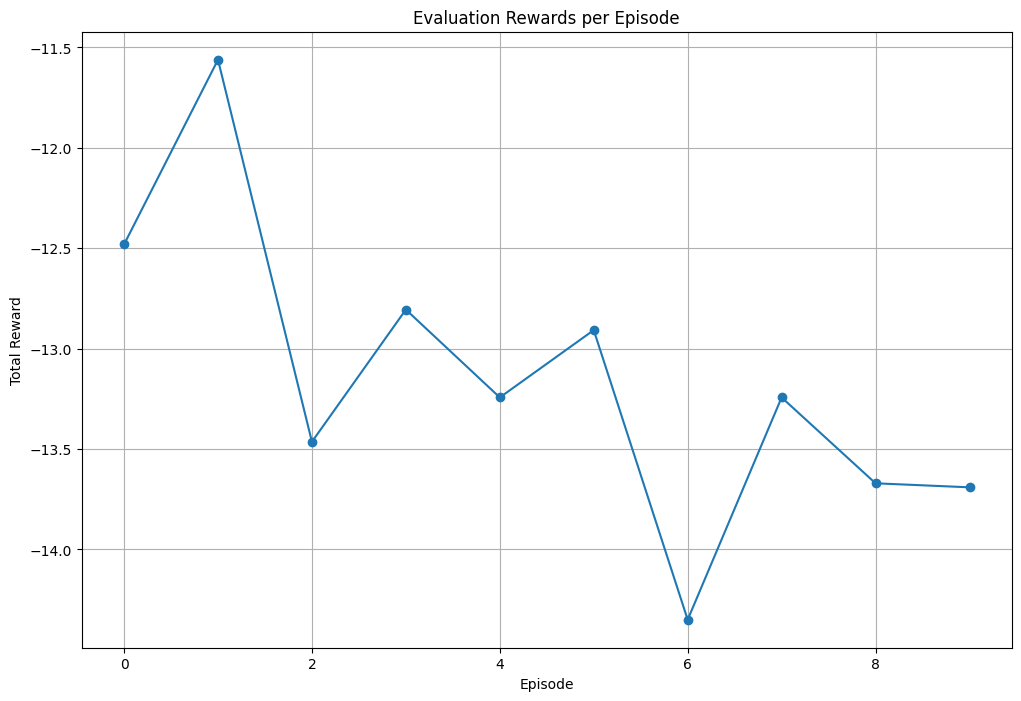

In [12]:
# Re-initialize the environment for evaluation
# Use the same parameters as the training environment
env = gym.make("CarRacing-v3",
               render_mode= None,
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

# ==== Evaluation ====
evaluation_episodes = 10 # Number of evaluation
score = []

for episode in range(evaluation_episodes):
  state = env.reset()
  if isinstance(state, tuple):
    state = state[0]

  total_reward = 0 # Track total reward per episode


  for time in range(max_step):
    action = np.argmax(model.predict(state[np.newaxis, ...], verbose=0)[0])
    next_state, reward, terminated, truncated, _ = env.step(action)

    if isinstance(next_state, tuple):
      next_state = next_state[0]

    done = terminated or truncated
    state = next_state
    total_reward = total_reward + float(reward)

    if done:
      break
  score.append(total_reward)
  print(f"Episode: {episode+1}/{evaluation_episodes}, Score: {total_reward:.2f}")

# ==== Scores ====
average_score = np.mean(score)
max_score = np.max(score)
min_score = np.min(score)
std_score = np.std(score)

print(f'Evaluation complete after {evaluation_episodes}')
print(f"Average Score: {average_score:.2f}")
print(f"Max Score: {max_score:.2f}")
print(f"Min Score: {min_score:.2f}")
print(f"Std Score: {std_score:.2f}")

# ==== Visualization ====
plt.figure(figsize=(12, 8))
plt.plot(score, marker='o')
plt.title("Evaluation Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

env.close()


## Video

⬇️ 我們視覺化車車！

In [13]:
def record_video(model, env, episodes=1, max_steps=200, output_path="car_racing_eval.mp4"):
    frames = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        for t in range(max_steps):
            # Get image frame
            frame = env.render()
            frames.append(frame)

            # Predict action
            q_values = model.predict(state[np.newaxis, ...], verbose=0)[0]
            action = np.argmax(q_values)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            state = next_state
            total_reward += reward

            if done:
                break

        print(f"🎬 Episode {ep+1} done. Total reward: {total_reward:.2f}")

    # Save video
    print(f"Saving video to {output_path}")
    imageio.mimsave(output_path, frames, fps=30)
    print("Video saved.")

In [16]:
# Re-initialize the environment for evaluation
# Use the same parameters as the training environment
env = gym.make("CarRacing-v3",
               render_mode="rgb_array",
               lap_complete_percent=0.95,
               domain_randomize=False,
               continuous=False)

record_video(model, env, episodes=1, max_steps=300, output_path="car_ai_demo.mp4")

🎬 Episode 1 done. Total reward: -23.59
Saving video to car_ai_demo.mp4


Video saved.
